# Weighted ECM clustering vs Traditional ECM clustering
### With IRIS (UCI dataset)

In [24]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
from evclust.utils import plotting, display_results_fuzzy_partition, display_results_evidential
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from evclust.ecm import ecm
from evclust.wecm_new_barycenter import wecm
from evclust.fcm.fcm_keller2000 import fcm as fcm_keller2000
from evclust.fcm.fcm_wang2004 import fcm as fcm_wang2004
from evclust.fcm.fcm_frigui2004 import scad1
from evclust.fcm.fcm_frigui2004 import scad2
from evclust.fcm.ifwfcm_xing2014 import fcm as ifwfcm_xing2014
from evclust.fcm.ifwfcm_kd_xing2014 import fcm as ifwfcm_kd_xing2014

   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


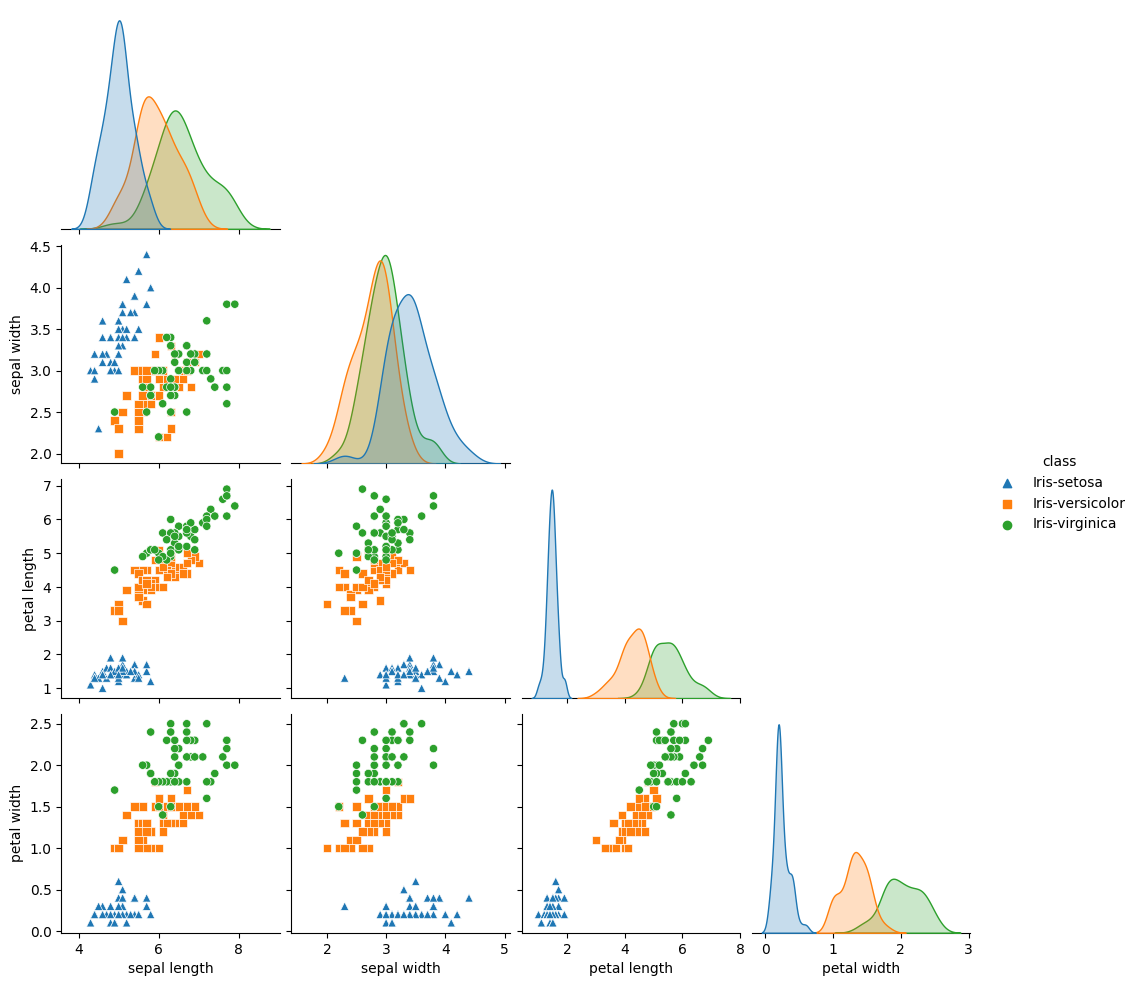

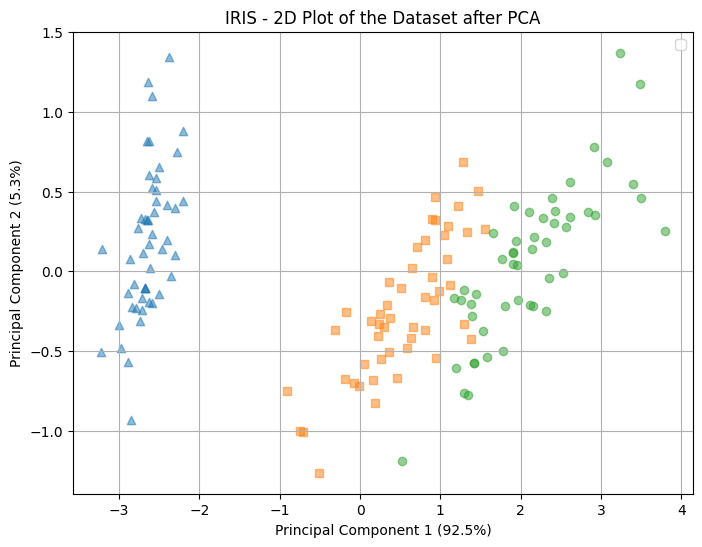

In [2]:
# fetch dataset - IRIS
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="IRIS", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
# %%capture
# Traditional ECM clustering
delta = np.sqrt(20)
ecm_models = np.array([])
for i in range(10):
    model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, ntrials=1, init="kmeans")
    ecm_models = np.append(ecm_models, model)

ecm_models = sorted(ecm_models, key=lambda x : x['crit'])

[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[1, 3.54292165279678]
[2, 3.5079291690106413]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.496114265526994]
[6, 3.4949799137722373]
[7, 3.4942277945449276]
[1, 3.5429216527967804]
[2, 3.5079291690106413]
[3, 3.500783480934679]
[4, 3.4978458161927035]
[5, 3.496114265526994]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[1, 3.5429216527967804]
[2, 3.5079291690106413]
[3, 3.500783480934679]
[4, 3.4978458161927035]
[5, 3.496114265526994]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[1, 3.5429216

J values: [3.4942277945449267, 3.494227794544927, 3.494227794544927, 3.494227794544927, 3.494227794544927, 3.494227794544927, 3.494227794544927, 3.494227794544927, 3.494227794544927, 3.4942277945449276]
ARI values: [0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762, 0.6770802856430762]
NS values: [1.2593004548624587, 1.2912110321862036, 1.249987587865042, 1.2912110321862036, 1.249987587865042, 1.3355218480192184, 1.249987587865042, 1.2912110321862036, 1.249987587865042, 1.3014535932180389]
NMI values: [0.7037042596540185, 0.7037042596540183, 0.7037042596540184, 0.7037042596540183, 0.7037042596540184, 0.7037042596540185, 0.7037042596540184, 0.7037042596540183, 0.7037042596540184, 0.7037042596540184]


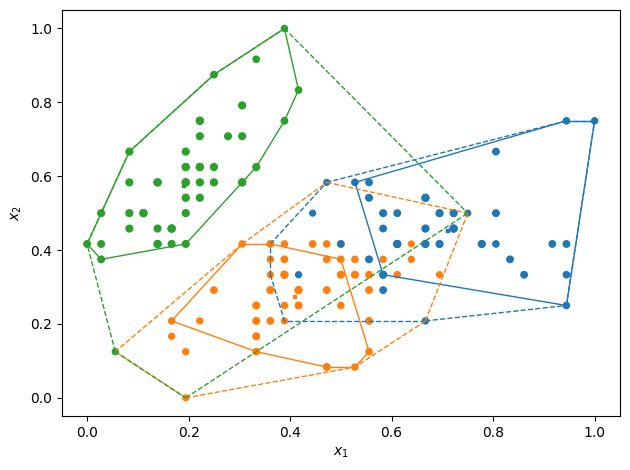

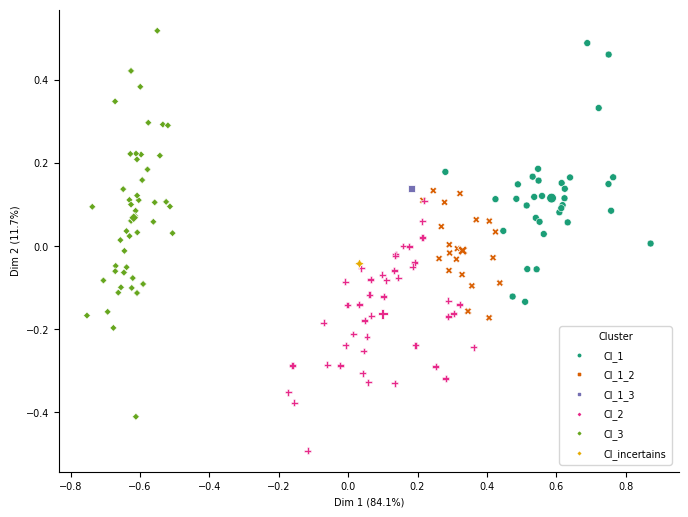

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

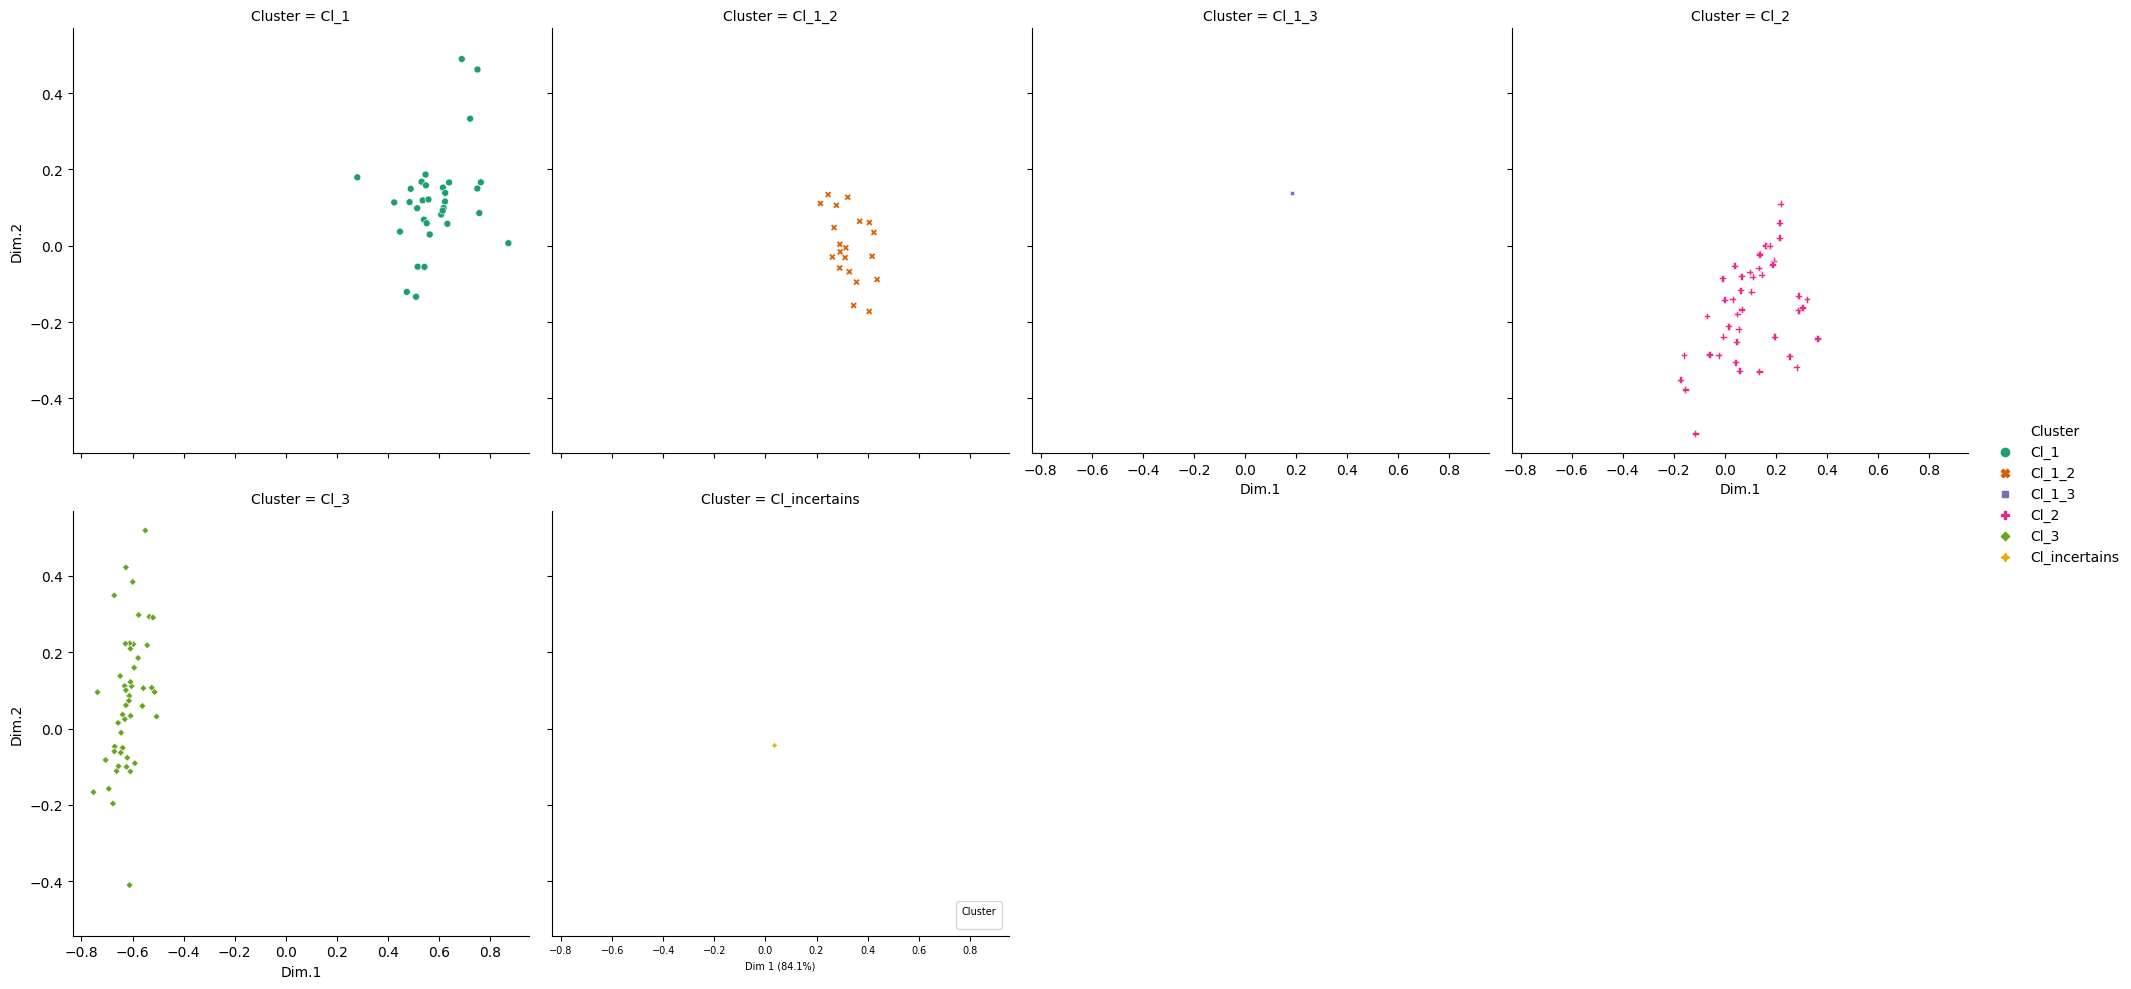

In [4]:
display_results_evidential(X, ecm_models, numeric_labels)

## Weighted ECM (WECM) with new equations of centers

In [5]:
# %%capture
# Weighted ECM clustering
wecm_models = np.array([])
c = 3
d = X.shape[1]
delta = np.sqrt(20)
for i in range(10):
    model = wecm(x=X, c=c, beta=2, alpha=1, delta=delta)
    wecm_models = np.append(wecm_models, model)

wecm_models = sorted(wecm_models, key=lambda model: model['crit'])

Initial weights: 
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Initial prototypes: 
 [[0.19611111 0.59083333 0.07864407 0.06      ]
 [0.44125683 0.30737705 0.57571548 0.54918033]
 [0.70726496 0.4508547  0.79704476 0.82478632]]
[1, 0.1979460864230703]
[2, 0.16310299343287177]
[3, 0.15433093063290393]
[4, 0.14801444269858763]
[5, 0.14235699331555374]
[6, 0.1360430687515327]
[7, 0.13000330090405113]
[8, 0.12536302040154823]
[9, 0.12042460922213913]
[10, 0.11744082039987919]
[11, 0.11642383938561468]
[12, 0.11543963003594385]
Initial weights: 
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Initial prototypes: 
 [[0.44125683 0.30737705 0.57571548 0.54918033]
 [0.19611111 0.59083333 0.07864407 0.06      ]
 [0.70726496 0.4508547  0.79704476 0.82478632]]
[1, 0.197

J values: [0.11543963003594346, 0.11543963003594346, 0.11543963003594347, 0.11543963003594347, 0.11543963003594347, 0.11543963003594385, 0.11543963003594385, 0.1154396300359443, 0.1154396300359443, 0.1154396300359443]
ARI values: [0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858, 0.7416919230031858]
NS values: [0.8837960475196954, 0.8837960475196954, 1.2290900569191354, 1.2290900569191354, 1.2290900569191354, 1.048625888429261, 1.048625888429261, 1.002001325152813, 1.002001325152813, 1.002001325152813]
NMI values: [0.7449573670061777, 0.7449573670061777, 0.7449573670061775, 0.7449573670061775, 0.7449573670061775, 0.7449573670061775, 0.7449573670061775, 0.7449573670061777, 0.7449573670061777, 0.7449573670061777]


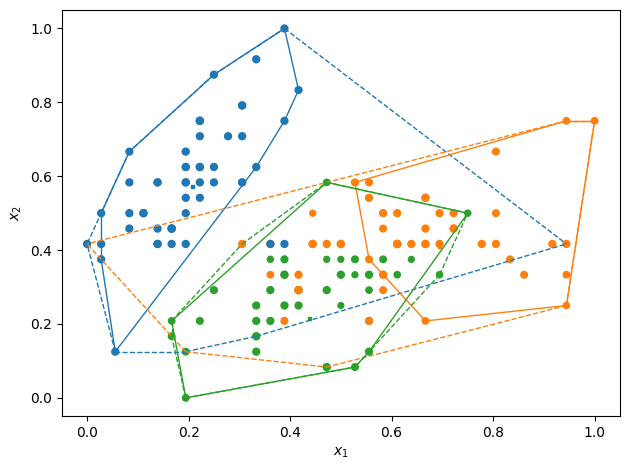

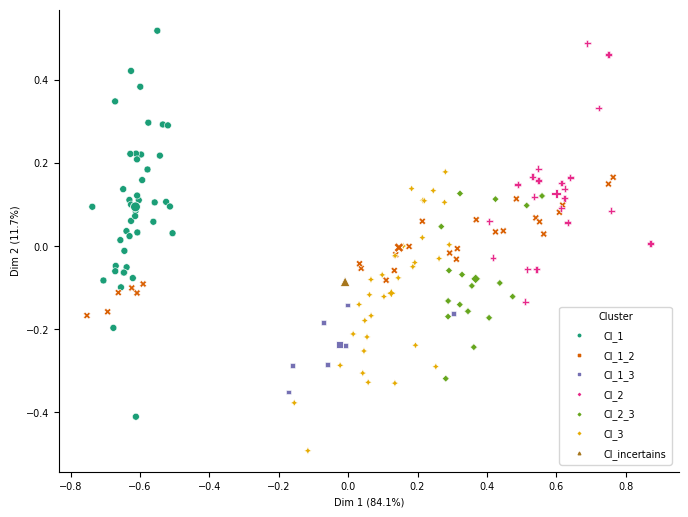

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

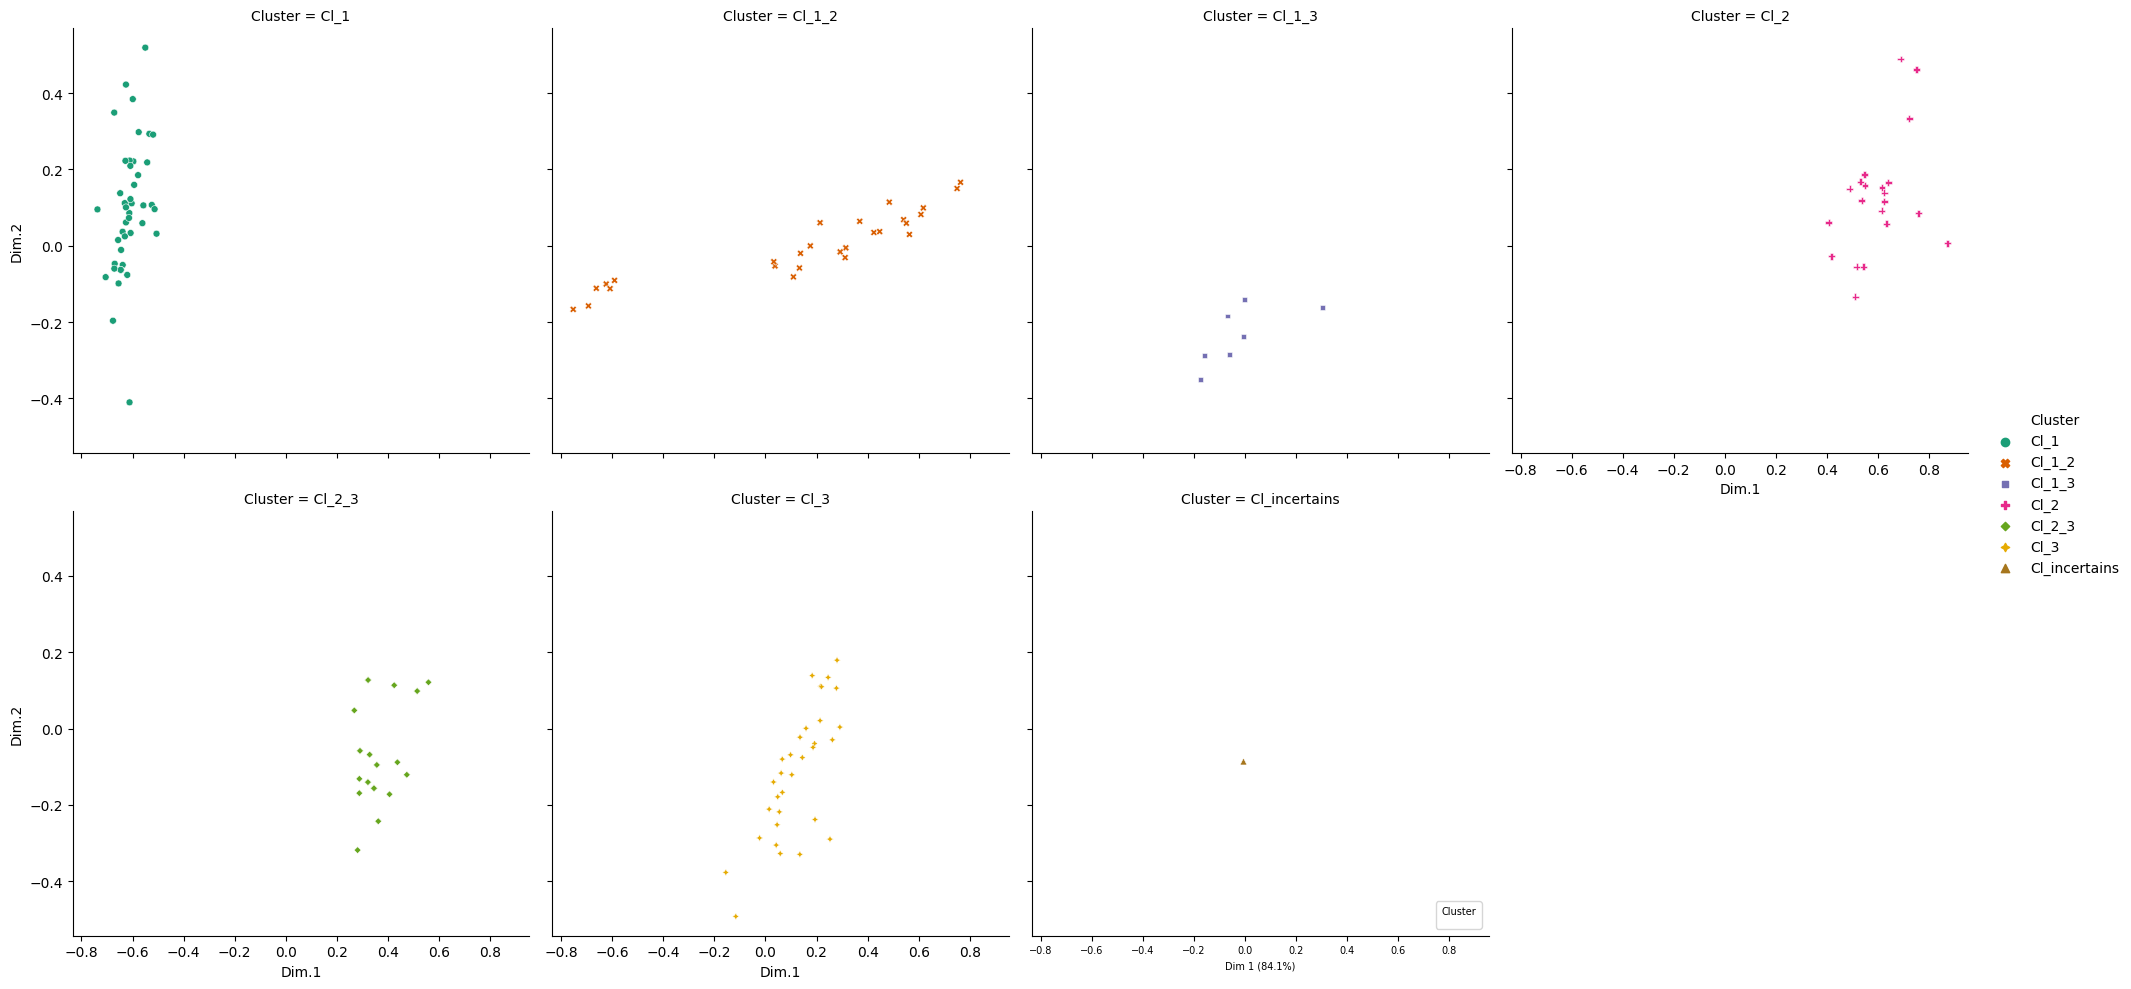

In [6]:
display_results_evidential(X, wecm_models, numeric_labels)

In [7]:
# top_weights = [model['W'] for model in wecm_models]
# for W in top_weights:
#     print(f"\n{W}")

# Weighted FCM - Keller et al. 2000

In [8]:
%%capture
keller_models = np.array([])
c = 3
# w0 = np.ones((c, X.shape[1])) / X.shape[1]
for i in range(10):
    model = fcm_keller2000(X, c, epsilon=1e-5, verbose=True)
    keller_models = np.append(keller_models, model)

J values: [0.24093274236675344, 0.24093193456443618, 0.2409287779476599, 0.2409343667882881, 0.24093051587733672, 0.2409309093553875, 0.2409340274701949, 0.2409320089755096, 0.24093227589041638, 0.24093110212143284]
ARI values: [0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019, 0.9037141640512019]
NMI values: [0.8801106732223013, 0.8801106732223013, 0.8801106732223013, 0.8801106732223013, 0.8801106732223013, 0.8801106732223011, 0.8801106732223013, 0.8801106732223011, 0.8801106732223013, 0.8801106732223013]


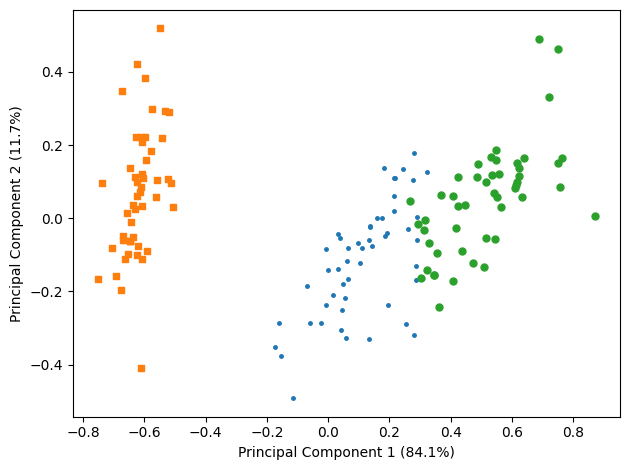

In [9]:
display_results_fuzzy_partition(X, keller_models, numeric_labels)

# Weighted FCM Wang 2004

In [11]:
wang_models = np.array([])
c = 3
for i in range(2):
    model = fcm_wang2004(X, c, w_beta=0.5, verbose=True)
    wang_models = np.append(wang_models, model)

Dataset includes 150 instances, and 4 features
Initial centers: [[0.44125683 0.30737705 0.57571548 0.54918033]
 [0.70726496 0.4508547  0.79704476 0.82478632]
 [0.19611111 0.59083333 0.07864407 0.06      ]]
Initial weights: [0.25 0.25 0.25 0.25]
Final initial weights: [ 8.14016076e-04 -5.01184459e-04 -7.95307951e-06 -2.91714378e-03]
[1, 1.9459177100432893e-06]
[2, 1.9789825118748446e-06]
Dataset includes 150 instances, and 4 features
Initial centers: [[0.19611111 0.59083333 0.07864407 0.06      ]
 [0.70726496 0.4508547  0.79704476 0.82478632]
 [0.44125683 0.30737705 0.57571548 0.54918033]]
Initial weights: [0.25 0.25 0.25 0.25]
Final initial weights: [ 8.14016076e-04 -5.01184459e-04 -7.95307951e-06 -2.91714378e-03]
[1, 1.7768624562165684e-06]
[2, 1.7589815458925846e-06]


J values: [1.9789825118748446e-06, 1.7589815458925846e-06]
ARI values: [0.8857921001989628, 0.8857921001989628]
NMI values: [0.870521418179061, 0.870521418179061]


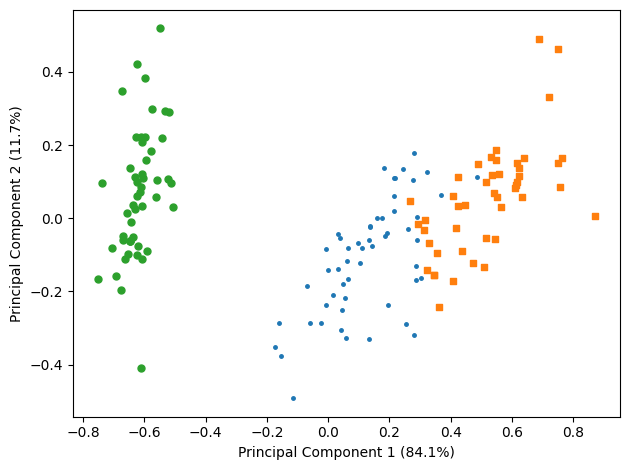

In [12]:
display_results_fuzzy_partition(X, wang_models, numeric_labels)

# SCAD1

In [16]:
%%capture
scad1_models = np.array([])
c = 3
for i in range(10):
    model = scad1(X, c, verbose=True)
    scad1_models = np.append(scad1_models, model)

J values: [3.484195295889102, 3.484195295889102, 3.4841952958891023, 3.484195295889102, 3.484195295889102, 3.484195295889102, 3.4841952958891023, 3.484195295889102, 3.4841952958891023, 3.484195295889102]
ARI values: [0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476, 0.7163421126838476]
NMI values: [0.7419116631817836, 0.7419116631817836, 0.7419116631817837, 0.7419116631817836, 0.7419116631817836, 0.7419116631817836, 0.7419116631817837, 0.7419116631817836, 0.7419116631817837, 0.7419116631817836]


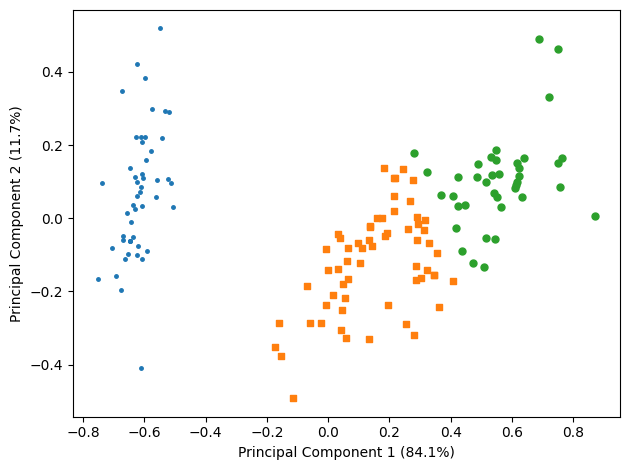

In [17]:
display_results_fuzzy_partition(X, scad1_models, numeric_labels)

# SCAD2

In [21]:
%%capture
scad2_models = np.array([])
c = 3
for i in range(10):
    model = scad2(X, c, verbose=True)
    scad2_models = np.append(scad2_models, model)

J values: [0.24919462784081142, 0.24919462784081142, 0.24919462784081142, 0.24919462784081142, 0.24919462784081137, 0.24919462784081137, 0.24919462784081142, 0.24919462784081137, 0.24919462784081137, 0.2491946278408114]
ARI values: [0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466]
NMI values: [0.7743507390201578, 0.7743507390201578, 0.7743507390201577, 0.7743507390201577, 0.7743507390201578, 0.7743507390201578, 0.7743507390201577, 0.7743507390201578, 0.7743507390201578, 0.7743507390201578]


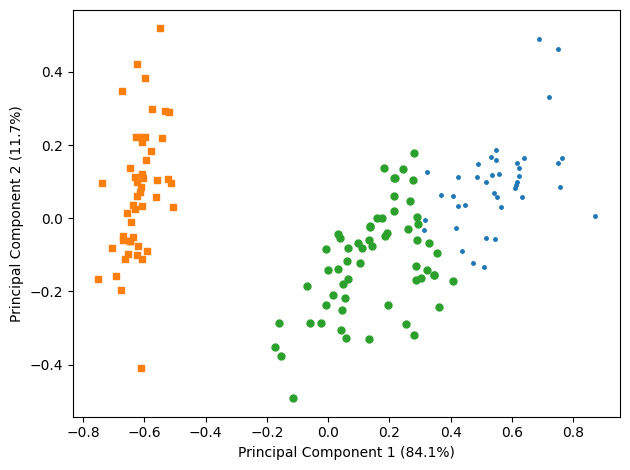

In [22]:
display_results_fuzzy_partition(X, scad2_models, numeric_labels)

# IFWFCM - Xing et al. 2014

In [32]:
%%capture
ifwfcm_models = np.array([])
c = 3
for i in range(10):
    model = ifwfcm_xing2014(X, c, verbose=True)
    ifwfcm_models = np.append(ifwfcm_models, model)

J values: [0.24919462784081142, 0.24919462784081142, 0.24919462784081142, 0.24919462784081142, 0.24919462784081137, 0.24919462784081137, 0.24919462784081142, 0.24919462784081137, 0.24919462784081137, 0.2491946278408114]
ARI values: [0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466]
NMI values: [0.7743507390201578, 0.7743507390201578, 0.7743507390201577, 0.7743507390201577, 0.7743507390201578, 0.7743507390201578, 0.7743507390201577, 0.7743507390201578, 0.7743507390201578, 0.7743507390201578]


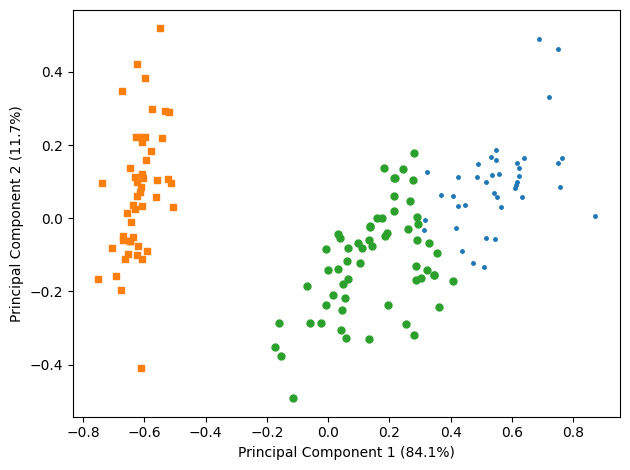

In [34]:
display_results_fuzzy_partition(X, scad2_models, numeric_labels)

# IFWFCM_KD Xing 2014

In [30]:
%%capture
ifwfcm_kd_models = np.array([])
c = 3
for i in range(10):
    model = ifwfcm_kd_xing2014(X, c, verbose=True)
    ifwfcm_kd_models = np.append(ifwfcm_kd_models, model)

J values: [0.24919462784081142, 0.24919462784081142, 0.24919462784081142, 0.24919462784081142, 0.24919462784081137, 0.24919462784081137, 0.24919462784081142, 0.24919462784081137, 0.24919462784081137, 0.2491946278408114]
ARI values: [0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466, 0.7576057289555466]
NMI values: [0.7743507390201578, 0.7743507390201578, 0.7743507390201577, 0.7743507390201577, 0.7743507390201578, 0.7743507390201578, 0.7743507390201577, 0.7743507390201578, 0.7743507390201578, 0.7743507390201578]


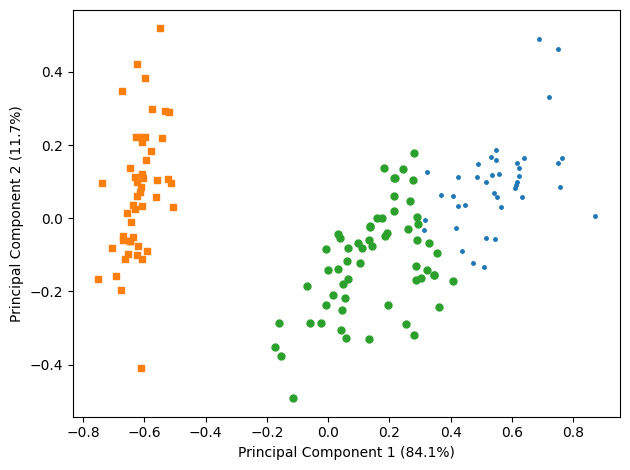

In [33]:
display_results_fuzzy_partition(X, scad2_models, numeric_labels)